# Didactalia, AFEL Activities and AFEL App Questionnaire Analysis

In this anaysis, we study the relations that may exist between the use of Didactalia or the AFEL App and the questionnaire on AFEL results.

# Import & Constants

## Fuseki Endpoint : you might want to change it!

In [1]:
FUSEKI_DATASET = "evalafel" # Change according your own dataset name
SPARQL_ENDPOINT = "http://localhost:3030/%s/query" % FUSEKI_DATASET

## Imports, constants settings

In [2]:
from SPARQLWrapper import SPARQLWrapper, CSV
from rdflib import Literal
import numpy as np
import pandas as pd
from io import BytesIO
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from itertools import combinations

In [3]:
SPARQL_PREFIX = """
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX afl: <http://vocab.afel-project.eu/>
    PREFIX extafl: <http://vocab.afel-project.eu/extension/>
    PREFIX sch: <http://schema.org/>
"""

In [4]:
# Setting seaborn to have proper visualisation adapted to jupyter notebook
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [5]:
def sparql_to_dataframe(query, **kwargs):
    sparql = SPARQLWrapper(SPARQL_ENDPOINT)
    sparql.setQuery(query)
    sparql.setReturnFormat(CSV)
    res = sparql.query().convert()
    try:
        with BytesIO(res) as sio:
            return pd.read_csv(sio, **kwargs)
    finally:
        del res
        gc.collect()

# Activity extraction

In [6]:
def retrieve_users_activities():
    """
    Retrieve following activities:
        - didactlia: Artifact view, game played, search
        - AFEL App: Artifact view, RecommendedArtifact view
    """
    query = SPARQL_PREFIX + """
    SELECT ?userid ?location ?activityType ?actStartTime ?actEndTime
    WHERE {
        ?activity a ?activityType .
        ?activity afl:user ?user .
        ?activity afl:eventStartDate ?actStartTime .
        ?activity afl:eventEndDate ?actEndTime .
        ?activity sch:location ?location .
        ?user afl:userName ?userid .
        FILTER(?location IN ("https://didactalia.net", "http://afel-project.eu/"))
    }
    """
    return sparql_to_dataframe(query, parse_dates=[3, 4])

In [7]:
def extract_users_activities(df, copy = False):
    if copy:
        df = df.copy()
    # Simplify users' ids
    df['userid'] = np.vectorize(int)(df.userid.str.extract('project.afel\+(\d+)', expand=False))
    # Simplify activityType
    df.activityType = df.activityType.str.split('/').str.get(-1)
    # Simplify location name
    df.loc[df.location == "https://didactalia.net", 'location'] = "didactalia"
    df.loc[df.location != "didactalia", 'location'] = "afel"
    # Sort by userid and actStartTime
    df.sort_values(['userid', 'actStartTime'], inplace=True)
    return df

In [8]:
def compute_activity_count(df):
    return df.loc[:, ['userid', 'location', 'actStartTime']]\
    .groupby(['userid', 'location']).count()\
    .rename(columns={'actStartTime': 'nbAct'})\
    .reset_index()\
    .pivot_table(index='userid', columns='location', values='nbAct', fill_value=0, aggfunc='sum')\
    .rename(columns={'afel':'afelNbAct', 'didactalia':'didactaliaNbAct'})
    

In [9]:
DF_ACTIVITY = compute_activity_count(extract_users_activities(retrieve_users_activities()))

# AFEL Questionnaire Extraction

In [10]:
def retrieve_afel_questionnaire_results():
    """
    Retrieve rated answers to the afel questionnaire:
    """
    query = SPARQL_PREFIX + """
    SELECT ?userid ?questionID ?ratingValue
    WHERE {
        ?action a sch:ChooseAction .
        ?action sch:actionOption ?rating .
        ?rating a sch:Rating .
        ?action sch:object ?question .
        ?action sch:agent ?user .
        ?question sch:identifier ?questionID .
        ?rating sch:ratingValue ?ratingValue .
        ?user afl:userName ?userid .
        FILTER( REGEX(?questionID, "^AFEL_QUEST_APP_2")) .
    }
    """
    return sparql_to_dataframe(query)

In [11]:
def process_afel_questionnaire_results(df):
    '''
    '''
    df['questionID'] = df.questionID.str.extract('AFEL_QUEST_APP_2_(.*)', expand=False)
    # convert userid into simpler int userid
    df['userid'] = np.vectorize(int)(df.userid.str.extract('project.afel\+(\d+)', expand=False))
    # Pivot table to have questions as columns
    df = df.pivot(index='userid', columns='questionID', values='ratingValue')
    return df

In [12]:
def retrieve_afel_questionnaire_info():
    """
    Retrieve rated answers to the afel questionnaire:
    """
    query = SPARQL_PREFIX + """
    SELECT DISTINCT ?questionID ?text
    WHERE {
        ?question a sch:Question .
        ?action a sch:ChooseAction .
        ?action sch:object ?question .
        ?question sch:identifier ?questionID .
        ?question sch:text ?text .
        FILTER( REGEX(?questionID, "^AFEL_QUEST_APP_2")) .
    }
    """
    return sparql_to_dataframe(query)

In [13]:
def process_afel_questionnaire_info(df):
    '''
    '''
    df['questionID'] = df.questionID.str.extract('AFEL_QUEST_APP_2_(.*)', expand=False)
    df = df.set_index('questionID')
    return df

In [14]:
def compute_questionnaire_stats(df):
    columns_simple_info = ['Age', 'Gender', 'LearnTask', 'Att_Tot', 'BehInt_Tot', 'EOU_Tot', 'SNorm_Tot', 
                           'PercUse_Tot', 'TechSE_Tot', 'SysAcc']
    columns_multiple_info = [('Dida', 5), ('Rec', 5), ('Vis', 3)]
    return pd.concat([df.loc[:, ['%s%d' % (c,i) for i in range(1,n+1)]]\
                                 .apply(func='mean', axis=1) for (c, n) in columns_multiple_info] +\
                                [df.loc[:, columns_simple_info]], axis=1)\
.rename(columns=dict((i,c[0]) for i,c in enumerate(columns_multiple_info)))

# Process

In [15]:
DF_QUEST_RES = process_afel_questionnaire_results(retrieve_afel_questionnaire_results())

In [16]:
DF_QUEST_INFO = process_afel_questionnaire_info(retrieve_afel_questionnaire_info())

In [17]:
df_stats = compute_questionnaire_stats(DF_QUEST_RES)

In [18]:
df_all = pd.merge(df_stats, DF_ACTIVITY, on='userid', validate='one_to_one')

# Correlation analysis

In [19]:
def find_significant_correlations(df, threshold=0.05):
    stats = combinations(df.columns, 2)
    stats = (couple + tuple(pearsonr(df[couple[0]], df[couple[1]])) for couple in stats)
    stats = filter(lambda st: st[3] <= threshold, stats)
    stats = sorted(stats, key=lambda x: abs(x[2]), reverse=True)
    return stats

In [20]:
for v1, v2, r, pval in find_significant_correlations(df_all):
    print("%s ~ %s : r = %.3f p-value = %.5f" % (v1, v2, r, pval))

Att_Tot ~ BehInt_Tot : r = 0.881 p-value = 0.00000
Att_Tot ~ PercUse_Tot : r = 0.814 p-value = 0.00000
BehInt_Tot ~ PercUse_Tot : r = 0.773 p-value = 0.00000
Dida ~ Att_Tot : r = 0.748 p-value = 0.00000
EOU_Tot ~ SysAcc : r = 0.748 p-value = 0.00000
Dida ~ BehInt_Tot : r = 0.734 p-value = 0.00000
Dida ~ PercUse_Tot : r = 0.722 p-value = 0.00000
Att_Tot ~ SNorm_Tot : r = 0.687 p-value = 0.00000
TechSE_Tot ~ SysAcc : r = 0.640 p-value = 0.00000
SNorm_Tot ~ PercUse_Tot : r = 0.634 p-value = 0.00000
EOU_Tot ~ TechSE_Tot : r = 0.625 p-value = 0.00000
BehInt_Tot ~ SNorm_Tot : r = 0.620 p-value = 0.00000
Dida ~ SNorm_Tot : r = 0.570 p-value = 0.00000
SNorm_Tot ~ TechSE_Tot : r = 0.558 p-value = 0.00000
SNorm_Tot ~ SysAcc : r = 0.477 p-value = 0.00002
EOU_Tot ~ SNorm_Tot : r = 0.477 p-value = 0.00002
Att_Tot ~ EOU_Tot : r = 0.457 p-value = 0.00004
Att_Tot ~ SysAcc : r = 0.432 p-value = 0.00012
Dida ~ EOU_Tot : r = 0.371 p-value = 0.00114
BehInt_Tot ~ EOU_Tot : r = 0.368 p-value = 0.00126
EOU_T

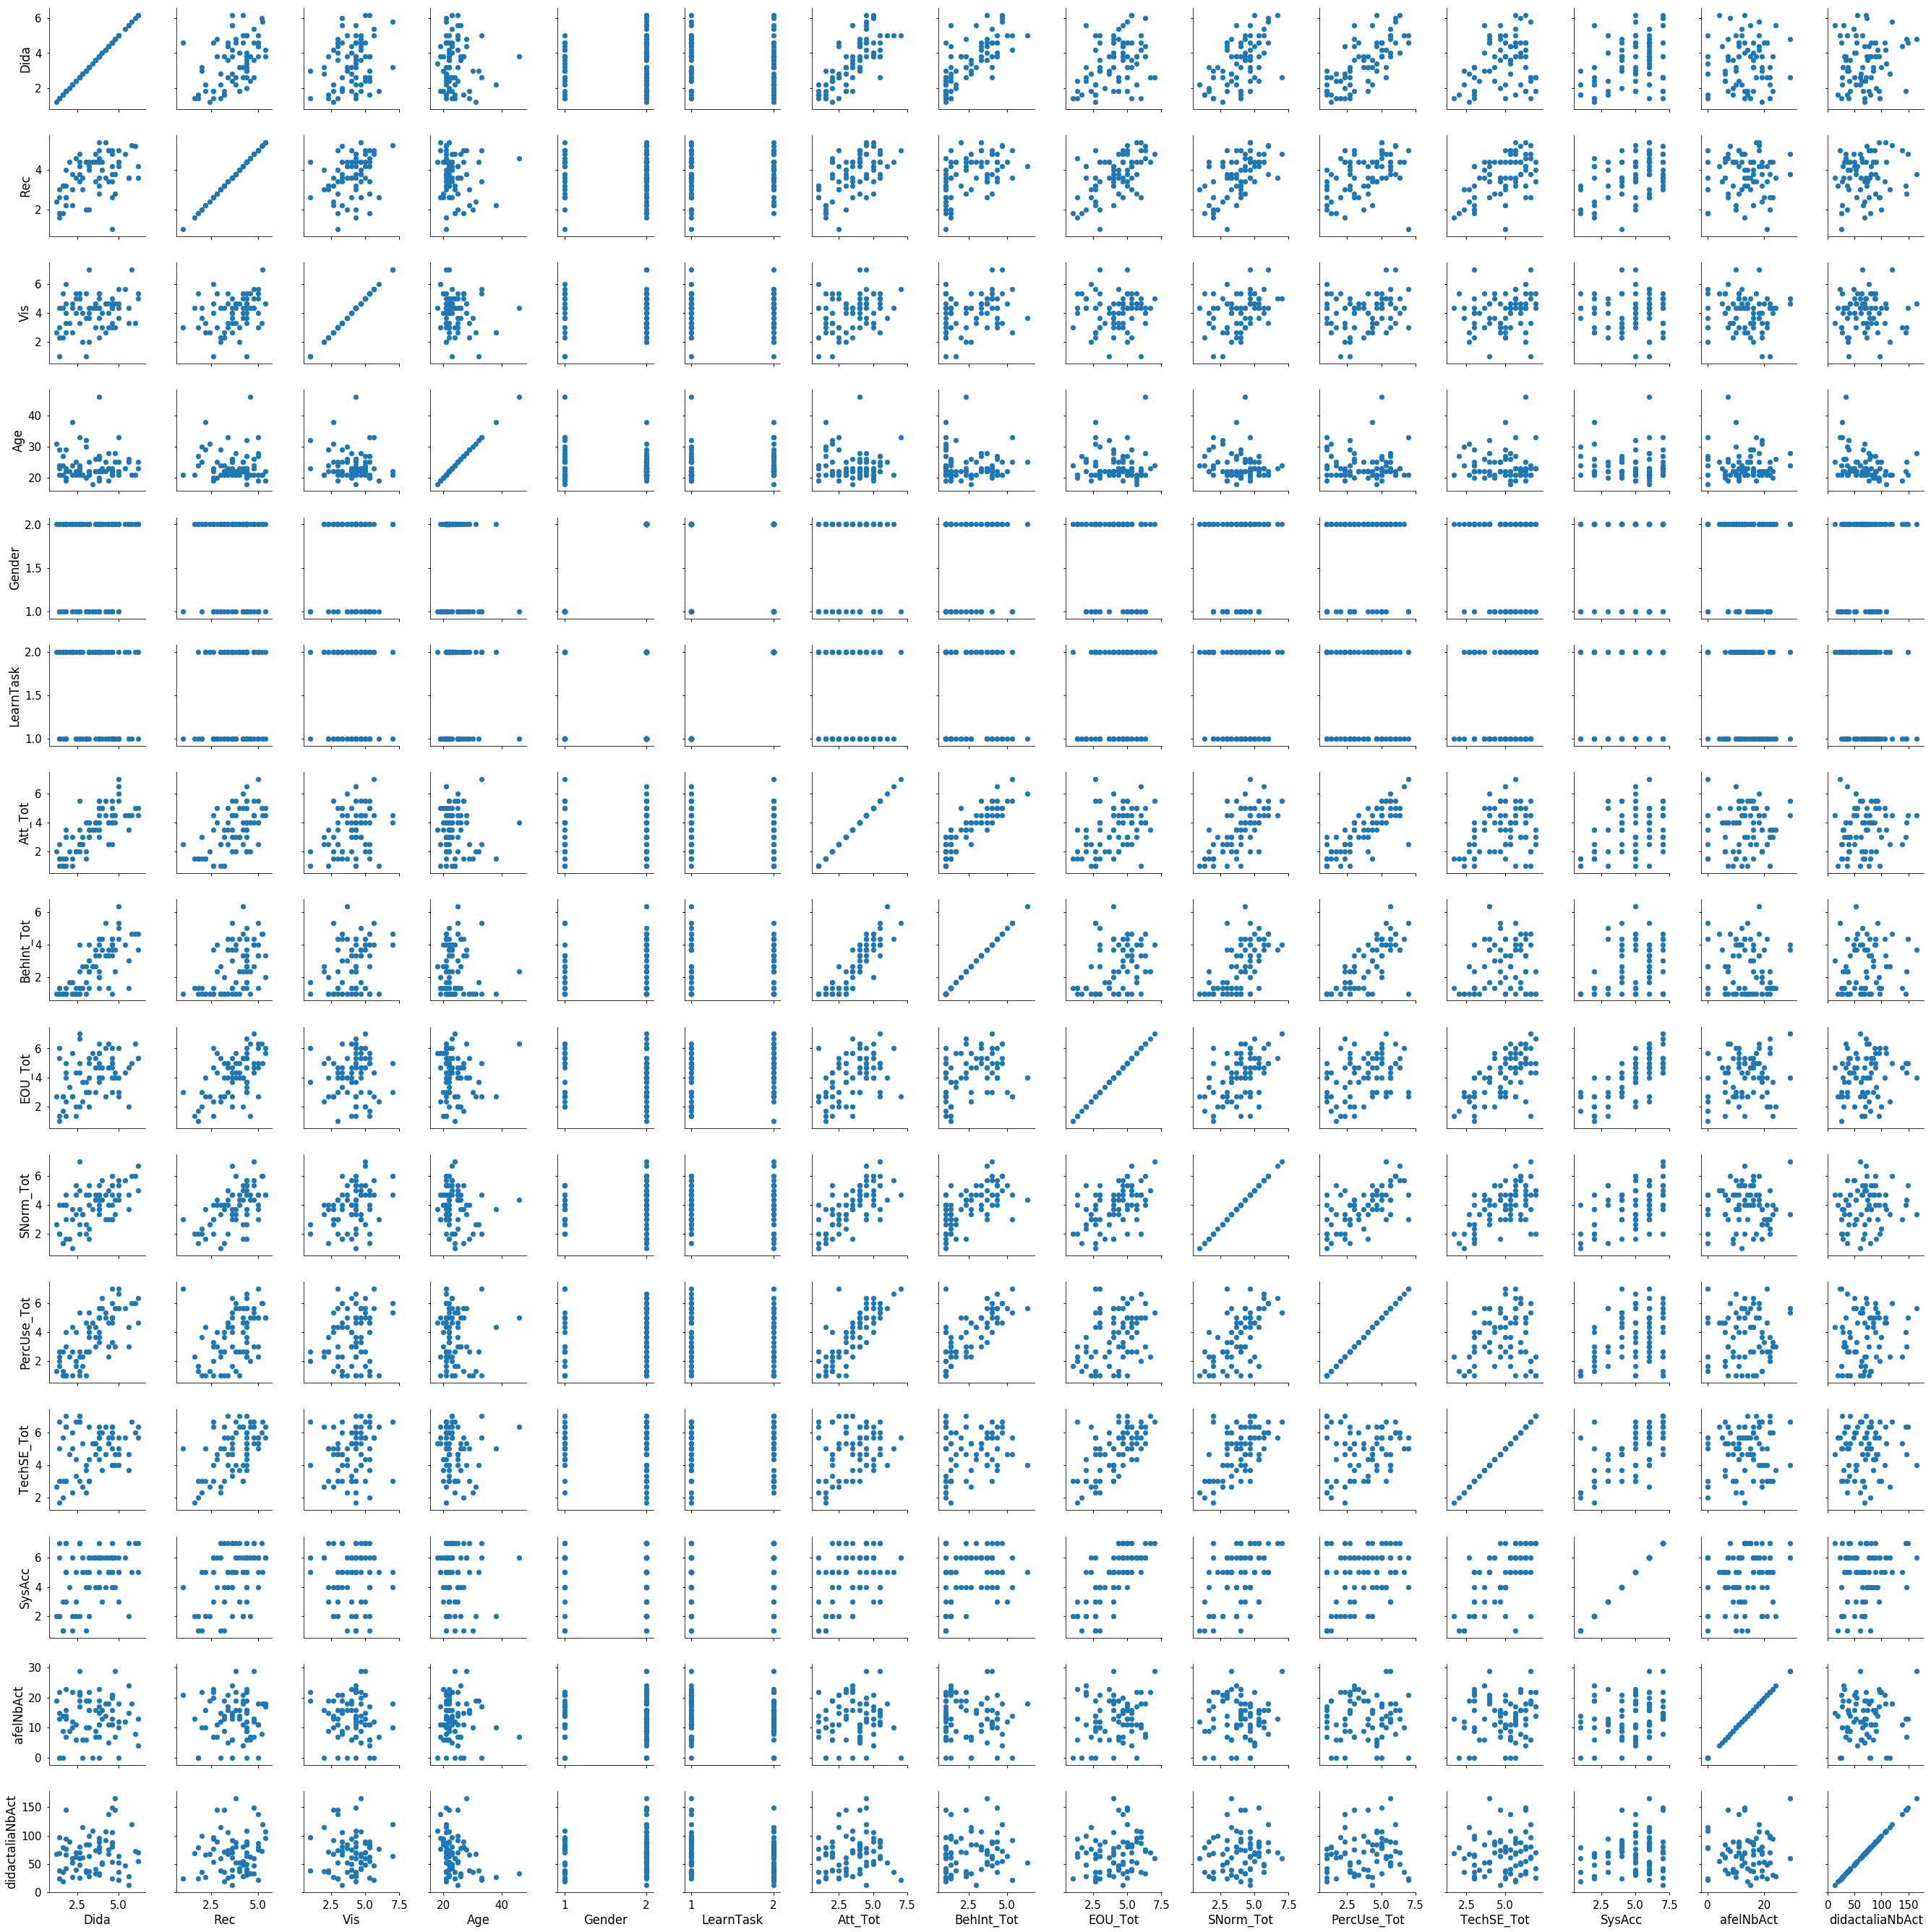

In [21]:
g = sns.PairGrid(df_all)
g = g.map(plt.scatter)